"""
Reconstruct retardance and orientation maps from images taken with different polarized illumination output
by Open PolScope. This script using the 4- or 5-frame reconstruction algorithm described in Michael Shribak and 
Rudolf Oldenbourg, 2003.

by Syuan-Ming Guo @ CZ Biohub 2018.3.30 
"""

In [11]:
%matplotlib inline
from PolScope.multiPos import findBackground
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import re

from utils.imgIO import GetSubDirName, ParseTiffInput, ParseFileList
from PolScope.reconstruct import computeAB, correctBackground, computeDeltaPhi
from utils.plotting import plot_birefringence, plot_sub_images

sns.set_context("poster")

In [18]:

def processImg(ImgSmPath, ImgBgPath, Chi, flatField=False):
    Abg, Bbg, IAbsBg, DAPIBg, TdTomatoBg = findBackground(ImgSmPath, ImgBgPath, Chi,flatField=flatField) # find background tile
    loopPos(ImgSmPath, Chi, Abg, Bbg, IAbsBg, DAPIBg, TdTomatoBg,flatField=flatField)

def loopPos(ImgSmPath, Chi, Abg, Bbg, IAbsBg, DAPIBg, TdTomatoBg, flatField=False): 
#loop through each position in the acquistion folder, perform flat-field correction       
    subDirName = GetSubDirName(ImgSmPath)          
    figPath = os.path.join(ImgSmPath, 'processed')
    ind=0
    for subDir in subDirName:
        plt.close("all") # close all the figures from the last run
        acquDirPath = os.path.join(ImgSmPath, subDir) # only load the first acquisition for now  
        if re.match( r'(\d?)-?Pos_?(\d+)_?(\d?)', subDir, re.M|re.I):                            
            PolChan, PolZ, FluorChan, FluorZ = ParseFileList(acquDirPath)
            loopZ(PolZ, ind, acquDirPath, figPath, Chi, Abg, Bbg, IAbsBg, DAPIBg, TdTomatoBg,flatField=flatField)
            ind+=1
def loopZ(PolZ, ind, acquDirPath, figPath, Chi, Abg, Bbg, IAbsBg, DAPIBg, TdTomatoBg, flatField=False):
    for z in PolZ:
        plt.close("all") # close all the figures from the last run
        DAPI = np.array([])
        TdTomato = np.array([])
        retardMMSm = np.array([])
        azimuthMMSm = np.array([])     
        ImgRawSm, ImgProcSm, ImgFluor = ParseTiffInput(acquDirPath, z)            
        ASm, BSm, IAbsSm = computeAB(ImgRawSm, Chi)        
        A, B = correctBackground(ASm,BSm,Abg,Bbg, ImgRawSm, extra=False)            
        retard, azimuth = computeDeltaPhi(A,B)        
        #retard = removeBubbles(retard)     # remove bright speckles in mounted brain slice images       
        retardBg, azimuthBg = computeDeltaPhi(Abg, Bbg)
        if ImgFluor.size:
            DAPI = ImgFluor[:,:,0]
            TdTomato = ImgFluor[:,:,1]
        if ImgProcSm.size:
            retardMMSm =  ImgProcSm[:,:,0]
            azimuthMMSm = ImgProcSm[:,:,1]
        if flatField:
            IAbsSm = IAbsSm/IAbsBg #flat-field correction 
            DAPI = DAPI/DAPIBg # #flat-field correction 
            TdTomato = TdTomato/TdTomatoBg  # #flat-field correction         
            
#            titles = ['Retardance (MM)','Orientation (MM)','Retardance (Py)','Orientation (Py)']
#            images = [retardMMSm, azimuthMMSm,retard, azimuth]
#            plot_sub_images(images,titles)
#            plt.savefig(os.path.join(acquDirPath,'compare_MM_Py.png'),dpi=200)
            
#        plot_birefringence(IAbsSm,retard, azimuth, figPath, int(z), DAPI=DAPI,
#                           TdTomato=TdTomato, spacing=6, vectorScl=0.5, zoomin=False, dpi=300)
        plot_birefringence(IAbsSm,retard, azimuth, figPath, ind, DAPI=DAPI,
                           TdTomato=TdTomato, spacing=20, vectorScl=1, zoomin=False, dpi=300)
#        figName = 'Transmission+Retardance+Orientation.png'
#        plt.savefig(os.path.join(acquDirPath, figName),dpi=300)
            


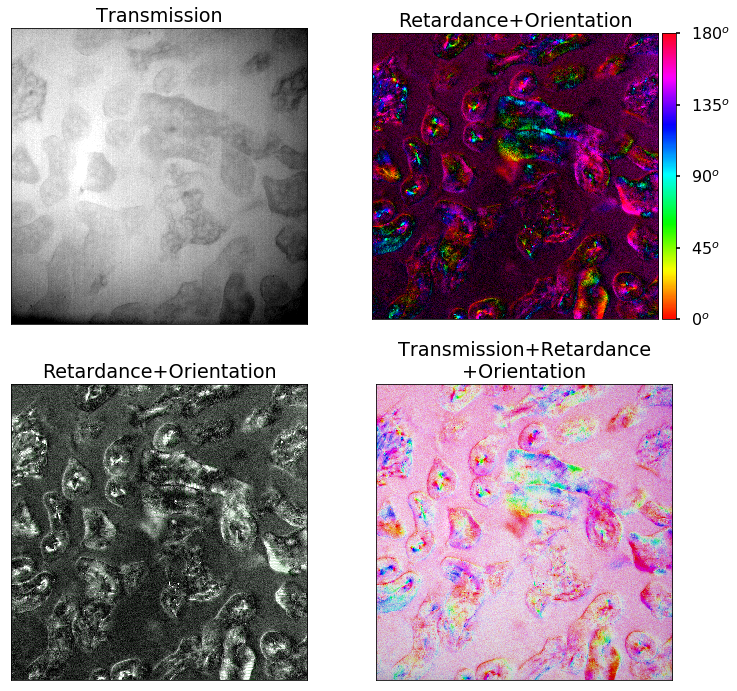

In [20]:
ImgSmPath = 'C:/Users/Sam Guo/Box Sync/Data/2018_05_09_KindneySection/SM_2018_0509_1804_1' # Sample image folder path
ImgBgPath = 'C:/Users/Sam Guo/Box Sync/Data/2018_05_09_KindneySection/BG_2018_0509_1801_1' # Background image folder path
Chi = 0.25 # Swing
#Chi = 0.1 # Swing
processImg(ImgSmPath, ImgBgPath, Chi, flatField=False)